In [38]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import AdamW

from transformers import get_scheduler
from sklearn.metrics import PredictionErrorDisplay


from jre_utils.datapath import model_ready_data_paths, model_output_data_paths
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesLSTMModel
from jre_utils.metrics import MSELossWeighted
from jre_utils.engine import (
    evaluate_weighted,
    train_weighted,
)


warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [39]:
asset_type = "all"

metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
    "weighted_mean_smoothed": "unit_price_wmean_smoothed",
    "weighted_median_smoothed": "unit_price_wmedian_smoothed",
    "mean_smoothed": "unit_price_mean_smoothed",
    "median_smoothed": "unit_price_median_smoothed",
}

granularity_columns = ["area", "area_code", "asset_type"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

metric_key_unsmoothed = "median"
metric_unsmoothed = metrics[metric_key_unsmoothed]

# metric_key = f"{metric_key_unsmoothed}_smoothed"
metric_key = "median"
metric = metrics[metric_key]

metric_pct_chg = metric + "_pct_chg"
normalized_metric_pct_chg = metric_pct_chg + "_normalized_yearly"

In [40]:
start_year = 2006
eval_start_year = 2020  # eval_years = [2020, 2021, 2022]
eval_end_year = 2022

dataset_key = "transactions"
years_ahead = 2
dataset_name = f"sequence_{dataset_key}_{asset_type}_{metric_key}_{years_ahead}"
output_dataset_name = f"{dataset_name}_{eval_start_year}"
model_ready_data_path = model_ready_data_paths[dataset_name]
model_output_data_path = model_output_data_paths[output_dataset_name]

df = pd.read_csv(model_ready_data_path)
df = df[df["year"] <= eval_end_year]
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)

# Weighting by count
# df["weight"] = df["count"].apply(lambda x: 1 + np.log10(x))

# Weighting by population
df["log_population"] = df["population"].apply(lambda x: np.log10(1 + x))
df["weight"] = df.groupby("year")["log_population"].transform(lambda x: x - x.min() + 1)

train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)]
train_df = train_df[~train_df[metric_pct_chg].isna()].reset_index(drop=True)

eval_df = df[df["year"] >= eval_start_year]
eval_df = eval_df[~eval_df[metric_pct_chg].isna()].reset_index(drop=True)

# Finally
df = df.fillna(0)

print(f"Train: {train_df.shape}, Eval: {eval_df.shape}")
# Try only for building. Try training separately for building. 

Train: (29837, 55), Eval: (8122, 55)


<Axes: ylabel='Frequency'>

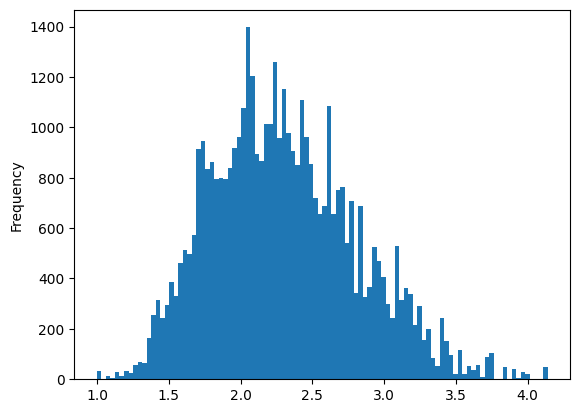

In [41]:
df["weight"].plot.hist(bins = 100)

In [42]:
train_df[(train_df["area_code"] == 13101) & (train_df["asset_type"] == "building")][["year", metric, metric_pct_chg, normalized_metric_pct_chg]]

,year,unit_price_median,unit_price_median_pct_chg,unit_price_median_pct_chg_normalized_yearly
59,2007,2.271493e+06,0.393871,0.983720
199,2008,2.333333e+06,0.105263,0.022257
2148,2009,1.920000e+06,-0.154741,-0.316067
3139,2010,2.037037e+06,-0.126984,-0.215148
7634,2011,1.444444e+06,-0.247685,-0.672931
9432,2012,1.455556e+06,-0.285455,-0.658649
11476,2013,2.303030e+06,0.594406,1.149448
13981,2014,2.000000e+06,0.374046,0.689789
18705,2015,2.173913e+06,-0.056064,-0.243456
19238,2016,2.645833e+06,0.322917,0.263091


In [43]:
eval_df[(eval_df["area_code"] == 13101) & (eval_df["asset_type"] == "building")][["year", metric, metric_pct_chg, normalized_metric_pct_chg]]

,year,unit_price_median,unit_price_median_pct_chg,unit_price_median_pct_chg_normalized_yearly
836,2020,3.787942e+06,0.237409,0.186068
5063,2021,4.420875e+06,0.312098,0.326362
6045,2022,4.333333e+06,0.143981,0.108697


In [44]:
idx = 2983
row = eval_df.iloc[idx]
target = row[normalized_metric_pct_chg]
area_code, asset_type, year = row["area_code"], row["asset_type"], row["year"]
window = (
    df[
        (df["area_code"] == area_code)
        & (df["asset_type"] == asset_type)
        & (df["year"] <= year - 2)
    ]
    .sort_values(by="year")
    .tail(5)
)
print(f"Target: {target}")
window["time_diff"] = year - window["year"]
window

Target: 1.0143460112468683


,area_code,area,year,asset_type,unit_price_median_pct_chg,count_growth,yearly_price_growth,total_tax_growth,taxable_income_growth,taxable_income_per_taxpayer_growth,net_migration_ratio,new_dwellings_ratio,taxpayer_count_growth,unit_price_median,count,total_traded_area,in_migrations,out_migrations,population,taxpayer_count,taxable_income,taxable_income_per_taxpayer,total_tax,new_dwellings,existing_dwellings,unit_price_median_log_normalized_yearly,count_log_normalized_yearly,total_traded_area_log_normalized_yearly,in_migrations_log_normalized_yearly,out_migrations_log_normalized_yearly,population_log_normalized_yearly,taxpayer_count_log_normalized_yearly,taxable_income_log_normalized_yearly,taxable_income_per_taxpayer_log_normalized_yearly,total_tax_log_normalized_yearly,new_dwellings_log_normalized_yearly,existing_dwellings_log_normalized_yearly,unit_price_median_pct_chg_normalized_yearly,count_growth_normalized_yearly,yearly_price_growth_normalized_yearly,total_tax_growth_normalized_yearly,taxable_income_growth_normalized_yearly,taxable_income_per_taxpayer_growth_normalized_yearly,net_migration_ratio_normalized_yearly,new_dwellings_ratio_normalized_yearly,taxpayer_count_growth_normalized_yearly,migrations_is_available,taxable_income_is_available,dwellings_is_available,total_tax_is_available,metric_pct_chg_is_available,condo,land,log_population,weight,time_diff
22669,20403,Nagano-ken Takamori-machi,2015,building,0.213557,0.600000,2.214286,-0.032568,0.037940,0.030918,-0.003085,0.0,0.006811,32142.857143,8.0,4590.0,312.0,352.0,12967.0,5617.0,15244766.0,2714.040591,1406967.0,0.0,0.0,-0.477051,-1.295318,-0.905731,-0.637383,-0.685530,-0.475794,-0.349078,-0.341150,-0.116429,-0.452514,0.0,0.0,0.268296,1.319042,3.681321,-0.341276,0.753819,0.589718,0.075404,0.0,0.487030,1,1,0,1,1,0.0,0.0,4.112873,1.665405,6
25473,20403,Nagano-ken Takamori-machi,2016,building,1.304348,-0.625000,-0.283092,0.005696,-0.000509,-0.004762,-0.002553,0.0,0.004273,23043.478261,3.0,1530.0,309.0,342.0,12927.0,5641.0,15237001.0,2701.117001,1414981.0,0.0,0.0,-0.816039,-1.973135,-1.908905,-0.625480,-0.674848,-0.474370,-0.355065,-0.356907,-0.216695,-0.457341,0.0,0.0,1.612265,-1.843592,-0.756066,-0.029449,-0.715986,-0.550175,0.086078,0.0,-0.521563,1,1,0,1,1,0.0,0.0,4.111531,1.664063,5
28661,20403,Nagano-ken Takamori-machi,2017,building,-0.670034,2.666667,-0.539737,0.012584,0.023271,0.014816,-0.000543,0.0,0.008332,10606.060606,11.0,7665.0,346.0,353.0,12894.0,5688.0,15591583.0,2741.136252,1432787.0,0.0,0.0,-1.495781,-1.062452,-0.432418,-0.544880,-0.649330,-0.473016,-0.354254,-0.352101,-0.172480,-0.460871,0.0,0.0,-1.266965,6.754654,-1.184022,0.140219,0.135389,0.169129,0.342225,0.0,-0.012483,1,1,0,1,1,0.0,0.0,4.110421,1.659249,4
29903,20403,Nagano-ken Takamori-machi,2018,building,-0.029295,-0.363636,1.109023,-0.008578,0.020715,0.006907,-0.000698,0.0,0.013713,22368.421053,7.0,2890.0,336.0,345.0,12887.0,5766.0,15914557.0,2760.068852,1420497.0,0.0,0.0,-0.802944,-1.401701,-1.335174,-0.552823,-0.658921,-0.470151,-0.348043,-0.348848,-0.197708,-0.467567,0.0,0.0,-0.197273,-1.094657,0.483792,-0.401970,0.061686,-0.116056,0.366117,0.0,0.407298,1,1,0,1,1,0.0,0.0,4.110186,1.658399,3
34295,20403,Nagano-ken Takamori-machi,2019,building,1.415418,-0.142857,0.145279,0.011773,0.020482,0.012057,-0.005203,0.0,0.008325,25618.073316,6.0,3040.0,306.0,373.0,12878.0,5814.0,16240520.0,2793.347093,1437220.0,0.0,0.0,-0.642300,-1.484323,-1.245132,-0.594844,-0.606867,-0.467195,-0.342080,-0.339254,-0.159335,0.783473,0.0,0.0,1.844586,-0.452524,0.071145,0.074241,0.259852,0.128179,-0.118980,0.0,0.350572,1,1,0,1,1,0.0,0.0,4.109882,1.658096,2


In [45]:
log_normalize_columns = [
    metric,
    # "count",
    # "total_traded_area",
    # "in_migrations",
    # "out_migrations",
    # "population",
    # "taxpayer_count",
    # "taxable_income",
    # "taxable_income_per_taxpayer",
    # "total_tax",
    # "new_dwellings",
    # "existing_dwellings",
]

normalize_columns = [
    metric_pct_chg,
    # "yearly_price_growth",
    # "count_growth",
    # "total_tax_growth",
    # "taxable_income_growth",
    # "taxable_income_per_taxpayer_growth",
    # "net_migration_ratio",
    # "new_dwellings_ratio",
    # "taxpayer_count_growth",
]

maintain_columns = [
    metric_pct_chg,
    # "migrations_is_available",
    # "taxable_income_is_available",
    # "dwellings_is_available",
    # "total_tax_is_available",
    # "metric_pct_chg_is_available",
]

id_columns = ["area_code", "area", "year", "asset_type"]

feature_columns = (
    [f"{column}_log_normalized_yearly" for column in log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in normalize_columns]
    + maintain_columns
    + (["condo", "land"] if asset_type == "all" else [])
)

final_columns = id_columns + feature_columns

In [46]:
time_series_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    feature_columns=feature_columns,
    shift=years_ahead
)

time_series_dataset_transformed = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    feature_columns=feature_columns,
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    shift=years_ahead
)

for i, sampleX in enumerate(time_series_dataset):
    print(
        i,
        sampleX["window"].shape,
        sampleX["target"].shape,
        sampleX["target"].values,
        sampleX["weight"].values,
    )
    if i == 3:
        break


for i, sampleY in enumerate(time_series_dataset_transformed):
    print(
        i,
        sampleY["window"].shape,
        sampleY["target"].shape,
        sampleY["target"],
        sampleY["weight"],
    )
    if i == 3:
        break

0 (1, 3) (1,) [-0.5143595] [2.5089209]
1 (1, 3) (1,) [-0.01942592] [2.26179947]
2 (1, 3) (1,) [0.05233945] [2.8857632]
3 (1, 3) (1,) [-0.22611018] [3.96037426]
0 torch.Size([5, 3]) torch.Size([1]) tensor([-0.5144]) tensor([2.5089])
1 torch.Size([5, 3]) torch.Size([1]) tensor([-0.0194]) tensor([2.2618])
2 torch.Size([5, 3]) torch.Size([1]) tensor([0.0523]) tensor([2.8858])
3 torch.Size([5, 3]) torch.Size([1]) tensor([-0.2261]) tensor([3.9604])


In [47]:
BATCH_SIZE = 256

In [48]:
train_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)
eval_dataset = JapanRETimeSeriesDataset(
    df,
    eval_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

# Building the Transformer Model

In [49]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [50]:
n_features = len(feature_columns)
d_hid = 64
nlayers = 2
dropout = 0

model = TimeSeriesLSTMModel(
    n_features=n_features,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    device=device,
)
model = model.to(device)


In [51]:
model.eval()

mse_loss_weighted = MSELossWeighted().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)
        
        print("Loss:", loss.item())

        break

torch.Size([256, 5, 3]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 2.8442723751068115


In [52]:
learning_rate = 1e-2 # 3e-4
weight_decay = 0 # 1
num_epochs = 50

In [53]:
num_training_steps = num_epochs * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = get_scheduler(
    "linear", # constant
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [54]:
# progress_bar = tqdm(range(num_training_steps))
progress_bar = None

for epoch in range(num_epochs):
    train_loss, train_r2_score = train_weighted(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)
    
    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
    print(f"Train R^2: {train_r2_score:.4f}, Eval R^2: {eval_r2_score:.4f}")

# progress_bar.close()

Epoch: 0
Train Loss: 6.1051, Eval Loss: 4.9080
Train R^2: 0.2167, Eval R^2: 0.3678
Epoch: 1
Train Loss: 5.2042, Eval Loss: 4.9627
Train R^2: 0.3343, Eval R^2: 0.3570
Epoch: 2
Train Loss: 5.0636, Eval Loss: 4.8743
Train R^2: 0.3516, Eval R^2: 0.3666
Epoch: 3
Train Loss: 4.9440, Eval Loss: 4.8679
Train R^2: 0.3685, Eval R^2: 0.3663


KeyboardInterrupt: 

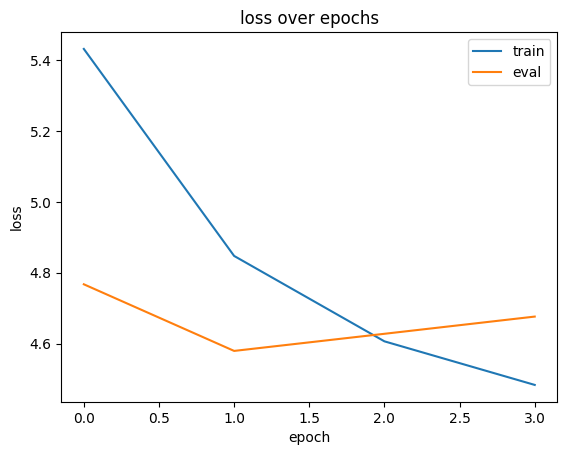

In [36]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

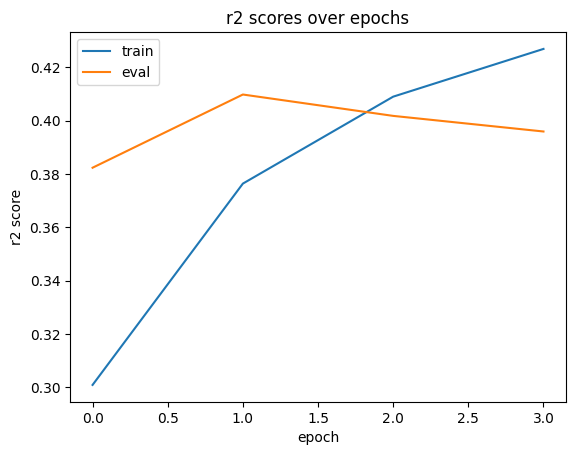

In [37]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()

In [35]:
# smoothed model
loss, epoch_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
print(f"Eval loss: {loss:.4f}")
print(f"Eval R2: {epoch_r2_score:.4f}")

Eval loss: 2.4709
Eval R2: 0.6796


In [36]:
def predict_return(model, area_code, year):
    area_df = df[(df["year"] == year) & (df["area_code"] == area_code)]

    area_dataset = JapanRETimeSeriesDataset(
        df,
        area_df,
        feature_columns=feature_columns,
        metrics=[normalized_metric_pct_chg],
        transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    )

    area_dataloader = DataLoader(
        area_dataset, batch_size=10, shuffle=False, num_workers=0
    )

    batch = next(iter(area_dataloader))
    
    model.eval()

    output = model(batch["window"].to(device), batch["mask"].to(device))
    return output.item()

In [37]:
years = [2020, 2021, 2022] # saving all predicted years.

prediction_df = df.copy()
prediction_df = prediction_df[prediction_df["year"].isin(years)]
prediction_df["predicted_normalized_return"] = prediction_df.apply(
    lambda row: predict_return(model, row["area_code"], row["year"]), axis=1
)
prediction_df = prediction_df.sort_values(
    by="year", ascending=False
)
prediction_df[
    [
        "year",
        "area_code",
        "predicted_normalized_return",
        metric_pct_chg,
        normalized_metric_pct_chg,
    ]
]

,year,area_code,predicted_normalized_return,unit_price_median_smoothed_pct_chg,unit_price_median_smoothed_pct_chg_normalized_yearly
18074,2022,27221,-1.298147,-0.313324,-1.323509
17324,2022,28212,-0.249031,-0.147399,-0.663334
17318,2022,15206,-0.854303,-0.233155,-1.004535
17319,2022,47348,1.672437,0.423042,1.606304
17320,2022,21361,-1.572772,-0.572982,-2.356621
...,...,...,...,...,...
15411,2020,24203,-0.396602,-0.157997,-1.050942
15410,2020,8214,-0.022239,-0.030913,-0.309195
15409,2020,27203,0.457672,0.166667,0.844006
15408,2020,14341,-0.595804,-0.160141,-1.063457


In [38]:
prediction_df[
    [
        "year",
        "area_code",
        "predicted_normalized_return",
        metric_pct_chg,
        normalized_metric_pct_chg,
    ]
].to_csv(model_output_data_path, index=False)

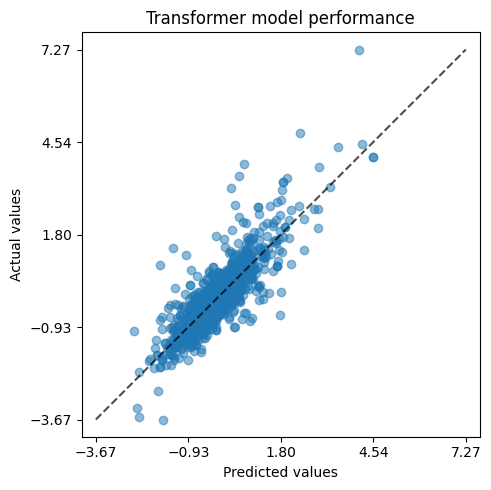

In [39]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[normalized_metric_pct_chg],
    prediction_df["predicted_normalized_return"],
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()

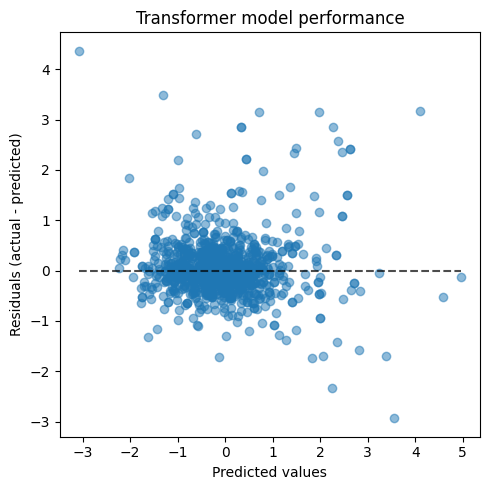

In [40]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[normalized_metric_pct_chg],
    prediction_df["predicted_normalized_return"],
    kind="residual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()